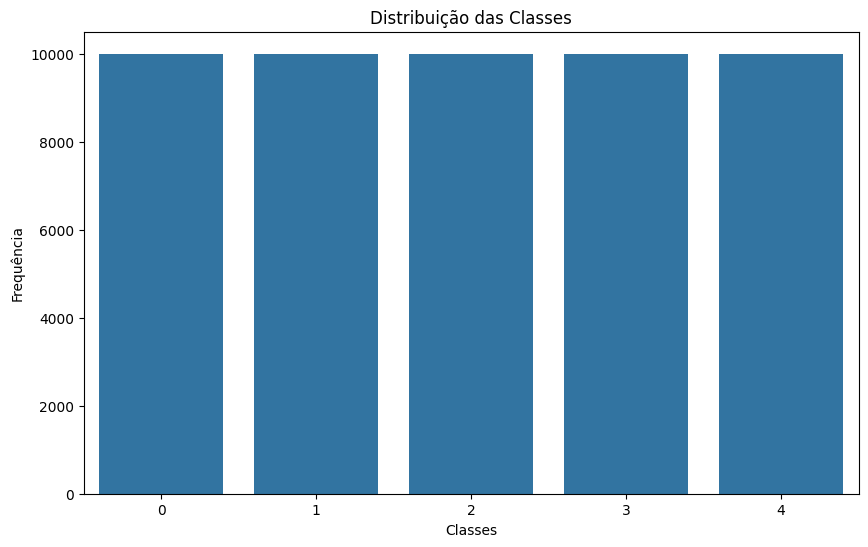

RandomForest Accuracy with SMOTE: 0.77758
XGBoost Accuracy with SMOTE: 0.73864


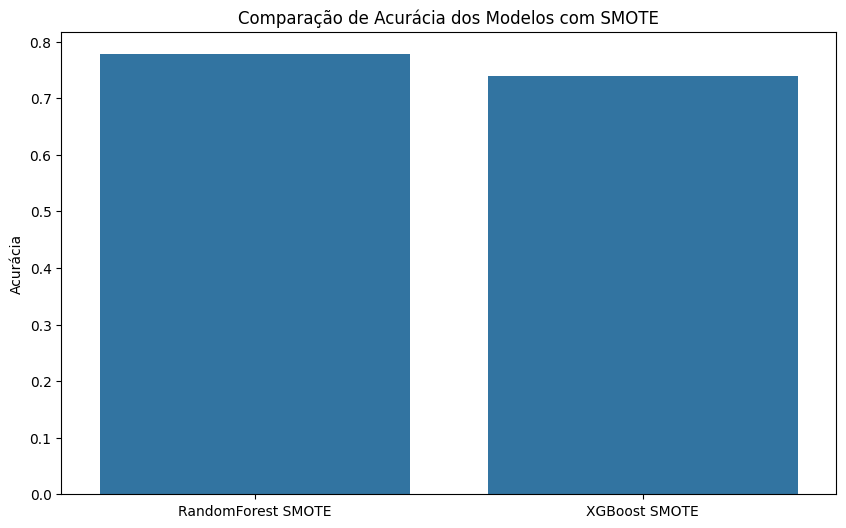

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def load_sensor_data(base_path):
    sensor_data = [np.load(f'{base_path}Dados_{i}.npy') for i in range(1, 6)]
    classes = np.load(f'{base_path}Classes.npy', allow_pickle=True)
    return sensor_data, classes

def preprocess_data(sensor_data, classes):
    combined_data = np.hstack(sensor_data + [np.zeros((sensor_data[0].shape[0], 1)) for _ in range(2)])
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    features_imputed = imputer.fit_transform(combined_data)
    features_scaled = scaler.fit_transform(features_imputed)
    label_encoder = LabelEncoder()
    targets = label_encoder.fit_transform(classes.ravel())
    return features_scaled, targets

def plot_class_distribution(targets):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=targets)
    plt.title('Distribuição das Classes')
    plt.xlabel('Classes')
    plt.ylabel('Frequência')
    plt.show()

def train_and_evaluate_model(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    model = OneVsRestClassifier(model)
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_test, classes=[*range(len(np.unique(y)))]), y_score, average='weighted', multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, auc, conf_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

sensor_data, classes = load_sensor_data('/content/')
X_scaled, y = preprocess_data(sensor_data, classes)
plot_class_distribution(y)

# Defining models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Training and evaluating models
for model in [rf_model, xgb_model]:
    accuracy, precision, recall, f1, auc, conf_matrix = train_and_evaluate_model(X_scaled, y, model)
    print(f"Model: {model.__class__.__name__}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1
